# Reference: Model Sounding with SkewT

Minimal example of requesting model sounding data from EDEX and plotting a SkewT with MetPy.

In [1]:
from awips.dataaccess import DataAccessLayer, ModelSounding
from shapely.geometry import Point
import matplotlib.pyplot as plt
import numpy as np
import metpy.calc as mpcalc
from metpy.plots import SkewT, Hodograph
from metpy.units import units
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [2]:
# Connect to EDEX
DataAccessLayer.changeEDEXHost("edex-cloud.unidata.ucar.edu")

# Define location (lon, lat) and model
point = Point(-97.0, 35.0)  # Oklahoma City area
model = "NAM40"

# Get latest forecast time
time_req = DataAccessLayer.newDataRequest("grid")
time_req.setLocationNames(model)
cycles = DataAccessLayer.getAvailableTimes(time_req, True)
times = DataAccessLayer.getAvailableTimes(time_req)
fcst_run = DataAccessLayer.getForecastRun(cycles[-1], times)
time_range = [fcst_run[0]]

print(f"Model: {model}, Time: {time_range[0]}")

Model: NAM40, Time: 2026-01-25 06:00:00 (0)


## Understanding the _SoundingCube Structure

`ModelSounding.getSounding()` returns a `_SoundingCube` object with a `_dataDict` attribute containing **three nested levels**:

```
sndObject._dataDict[TIME][LEVEL][PARAMETER] = value
```

| Nest | Description | Access Method |
|------|-------------|---------------|
| 1. **Time** | Forecast valid times (DataTime keys) | `snd._dataDict.keys()` |
| 2. **Level** | Vertical levels (e.g., '500MB', '0.0FHAG') | `snd._dataDict[time].levels()` |
| 3. **Parameter** | Weather variables (e.g., 'T', 'DpT', 'uW') | `snd._dataDict[time][level].parameters()` |

In [3]:
# Get a sample sounding to explore the _SoundingCube structure
sample_parms = ['T', 'DpT', 'uW', 'vW']
sample_levels = ['500MB', '700MB', '850MB', '925MB']

snd = ModelSounding.getSounding(model, sample_parms, sample_levels, point, time_range)

# === NEST 1: Query available TIMES ===
print("=" * 50)
print("NEST 1 - TIMES")
print("=" * 50)
print(f"Access: snd.times()")
print(f"Count: {len(snd._dataDict)} time(s)\n")
for time in snd._dataDict:
    print(f"  - {time}")

NEST 1 - TIMES
Access: snd.times()
Count: 1 time(s)

  - 2026-01-25 06:00:00 (0)


In [4]:
# === NEST 2: Query available LEVELS for a given time ===
first_time = list(snd._dataDict.keys())[0]

print("=" * 50)
print("NEST 2 - LEVELS")
print("=" * 50)
print(f"Access: snd._dataDict[time].levels()")
print(f"Time: {first_time}")
print(f"Count: {len(snd._dataDict[first_time].levels())} level(s)\n")
for lvl in snd._dataDict[first_time].levels():
    print(f"  - {lvl}")

NEST 2 - LEVELS
Access: snd._dataDict[time].levels()
Time: 2026-01-25 06:00:00 (0)
Count: 4 level(s)

  - 925.0MB
  - 850.0MB
  - 700.0MB
  - 500.0MB


In [5]:
# === NEST 3: Query available PARAMETERS for a given time and level ===
first_level = snd._dataDict[first_time].levels()[0]

print("=" * 50)
print("NEST 3 - PARAMETERS")
print("=" * 50)
print(f"Access: snd._dataDict[time][level].parameters()")
print(f"Time: {first_time}")
print(f"Level: {first_level}")
print(f"Count: {len(snd._dataDict[first_time][first_level].parameters())} parameter(s)\n")
for param in snd._dataDict[first_time][first_level].parameters():
    value = snd._dataDict[first_time][first_level][param]
    print(f"  - {param} = {value}")

NEST 3 - PARAMETERS
Access: snd._dataDict[time][level].parameters()
Time: 2026-01-25 06:00:00 (0)
Level: 925.0MB
Count: 4 parameter(s)

  - T = 257.47125244140625
  - vW = -12.593344688415527
  - DpT = 255.5290069580078
  - uW = -4.242275238037109


In [6]:
# Get surface data first (for surface pressure reference)
sfc_parms = ['T', 'DpT', 'uW', 'vW', 'P']
sfc = ModelSounding.getSounding(model, sfc_parms, ['0.0FHAG'], point, time_range)

pressure, temp, dwpt, u, v = [], [], [], [], []
for t in sfc._dataDict:
    pressure.append(float(sfc._dataDict[t]['0.0FHAG']['P']))
    temp.append(float(sfc._dataDict[t]['0.0FHAG']['T']))
    dwpt.append(float(sfc._dataDict[t]['0.0FHAG']['DpT']))
    u.append(float(sfc._dataDict[t]['0.0FHAG']['uW']))
    v.append(float(sfc._dataDict[t]['0.0FHAG']['vW']))

print(f"Surface pressure: {pressure[0]:.1f} MB")

Surface pressure: 982.8 MB


In [7]:
# Get all upper levels above surface
parms = ['T', 'DpT', 'uW', 'vW']
level_req = DataAccessLayer.newDataRequest("grid", envelope=point)
level_req.setLocationNames(model)
level_req.setParameters(*parms)
all_levels = DataAccessLayer.getAvailableLevels(level_req)

# Filter to MB levels above surface
upper_levels = [lvl for lvl in all_levels 
                if 'MB' in str(lvl) and '_' not in str(lvl)
                and float(str(lvl).replace('MB', '')) < pressure[0]]

# Get upper air sounding
upper = ModelSounding.getSounding(model, parms, upper_levels, point, time_range)

# Extract data by iterating through all three nests
for time in upper._dataDict:                              # Nest 1: Times
    for lvl in upper._dataDict[time].levels():            # Nest 2: Levels
        for param in upper._dataDict[time][lvl].parameters():  # Nest 3: Parameters
            val = float(upper._dataDict[time][lvl][param])
            if param == 'T': temp.append(val)
            elif param == 'DpT': dwpt.append(val)
            elif param == 'uW': u.append(val)
            elif param == 'vW': v.append(val)
        pressure.append(float(lvl.replace('MB', '')))

print(f"Retrieved {len(upper_levels)} levels")

Retrieved 38 levels


In [8]:
# Convert to arrays with units
p = np.array(pressure) * units.hPa
t = (np.array(temp) * units.K).to('degC')
td = (np.array(dwpt) * units.K).to('degC')
u = (np.array(u) * units('m/s')).to('knots')
v = (np.array(v) * units('m/s')).to('knots')
wspd = mpcalc.wind_speed(u, v)

/var/folders/9w/czmy8vgn76376hx2704_y62w0000gp/T/ipykernel_63956/1379155460.py:24: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper right')


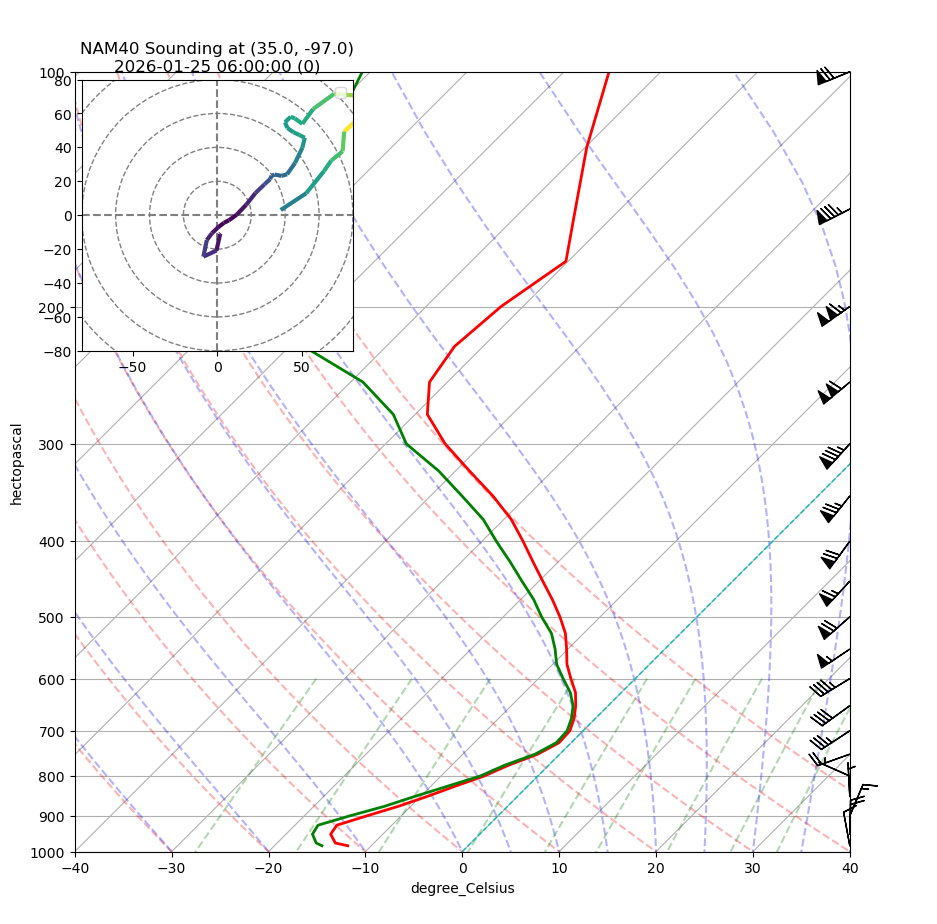

In [9]:
# Plot SkewT with Hodograph
fig = plt.figure(figsize=(10, 12))
skew = SkewT(fig, rotation=45)

skew.plot(p, t, 'r', linewidth=2, label='Temperature')
skew.plot(p, td, 'g', linewidth=2, label='Dewpoint')
skew.plot_barbs(p[::2], u[::2], v[::2])  # Every other level

skew.plot_dry_adiabats(alpha=0.3)
skew.plot_moist_adiabats(alpha=0.3)
skew.plot_mixing_lines(alpha=0.3)

skew.ax.set_ylim(1000, 100)
skew.ax.set_xlim(-40, 40)
skew.ax.axvline(0, color='c', linestyle='--', linewidth=1)

# Hodograph inset
ax_hod = inset_axes(skew.ax, '35%', '35%', loc='upper left')
h = Hodograph(ax_hod, component_range=80)
h.add_grid(increment=20)
h.plot_colormapped(u, v, wspd)

plt.title(f"{model} Sounding at ({point.y}, {point.x})\n{time_range[0]}")
plt.legend(loc='upper right')
plt.show()